In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/feature domain/frequency_domain_data.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

In [ ]:
# %%capture
# !pip install wandb

In [ ]:
# import wandb

In [ ]:
# !wandb login

# CNN-LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_callback = ModelCheckpoint(
                f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/best_model_{run_name}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Evaluate client model
            y_pred = (client_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 15s 57ms/step - loss: 0.6929 - accuracy: 0.5859 - val_loss: 0.6931 - val_accuracy: 0.5172
Epoch 2/100
29/29 [==============================] - 1s 20ms/step - loss: 0.6915 - accuracy: 0.7131 - val_loss: 0.6929 - val_accuracy: 0.5905
Epoch 3/100
29/29 [==============================] - 1s 21ms/step - loss: 0.6880 - accuracy: 0.7206 - val_loss: 0.6924 - val_accuracy: 0.5916
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.6801 - accuracy: 0.7328 - val_loss: 0.6912 - val_accuracy: 0.6756
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.6644 - accuracy: 0.7419 - val_loss: 0.6885 - val_accuracy: 0.7284
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.6347 - accuracy: 0.7390 - val_loss: 0.6826 - val_accuracy: 0.7446
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5901 - accuracy: 0.7425 - val_loss: 0.6726 - val_accuracy: 0.7338
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 79ms/step - loss: 0.6929 - accuracy: 0.5453 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.6918 - accuracy: 0.6811 - val_loss: 0.6930 - val_accuracy: 0.5057
Epoch 3/100
28/28 [==============================] - 1s 24ms/step - loss: 0.6893 - accuracy: 0.7139 - val_loss: 0.6927 - val_accuracy: 0.5136
Epoch 4/100
28/28 [==============================] - 1s 26ms/step - loss: 0.6842 - accuracy: 0.7122 - val_loss: 0.6920 - val_accuracy: 0.5781
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.6740 - accuracy: 0.7207 - val_loss: 0.6903 - val_accuracy: 0.6652
Epoch 6/100
28/28 [==============================] - 1s 31ms/step - loss: 0.6541 - accuracy: 0.7244 - val_loss: 0.6871 - val_accuracy: 0.6923
Epoch 7/100
28/28 [==============================] - 1s 31ms/step - loss: 0.6225 - accuracy: 0.7250 - val_loss: 0.6806 - val_accuracy: 0.7093
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 88ms/step - loss: 0.6929 - accuracy: 0.5602 - val_loss: 0.6931 - val_accuracy: 0.5434
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6914 - accuracy: 0.7036 - val_loss: 0.6929 - val_accuracy: 0.5165
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6879 - accuracy: 0.7212 - val_loss: 0.6924 - val_accuracy: 0.5455
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6800 - accuracy: 0.7271 - val_loss: 0.6911 - val_accuracy: 0.6550
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6632 - accuracy: 0.7266 - val_loss: 0.6882 - val_accuracy: 0.7004
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6312 - accuracy: 0.7351 - val_loss: 0.6819 - val_accuracy: 0.7397
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.5878 - accuracy: 0.7333 - val_loss: 0.6711 - val_accuracy: 0.7469
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 58ms/step - loss: 0.3076 - accuracy: 0.8707 - val_loss: 0.6772 - val_accuracy: 0.4871
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.2937 - accuracy: 0.8793 - val_loss: 0.6746 - val_accuracy: 0.4871
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 0.2934 - accuracy: 0.8839 - val_loss: 0.6688 - val_accuracy: 0.4968
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.2816 - accuracy: 0.8860 - val_loss: 0.6628 - val_accuracy: 0.5140
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.2817 - accuracy: 0.8850 - val_loss: 0.6561 - val_accuracy: 0.5409
Epoch 6/100
29/29 [==============================] - 1s 24ms/step - loss: 0.2765 - accuracy: 0.8925 - val_loss: 0.6471 - val_accuracy: 0.5938
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 0.2739 - accuracy: 0.8885 - val_loss: 0.6385 - val_accuracy: 0.6422
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 58ms/step - loss: 0.3267 - accuracy: 0.8571 - val_loss: 0.6776 - val_accuracy: 0.4966
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.3197 - accuracy: 0.8585 - val_loss: 0.6739 - val_accuracy: 0.5000
Epoch 3/100
28/28 [==============================] - 1s 24ms/step - loss: 0.3128 - accuracy: 0.8664 - val_loss: 0.6681 - val_accuracy: 0.5181
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3030 - accuracy: 0.8761 - val_loss: 0.6651 - val_accuracy: 0.5147
Epoch 5/100
28/28 [==============================] - 1s 28ms/step - loss: 0.2978 - accuracy: 0.8738 - val_loss: 0.6563 - val_accuracy: 0.6063
Epoch 6/100
28/28 [==============================] - 0s 15ms/step - loss: 0.3002 - accuracy: 0.8744 - val_loss: 0.6513 - val_accuracy: 0.6029
Epoch 7/100
28/28 [==============================] - 1s 22ms/step - loss: 0.2903 - accuracy: 0.8803 - val_loss: 0.6439 - val_accuracy: 0.6222
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 74ms/step - loss: 0.3066 - accuracy: 0.8703 - val_loss: 0.6783 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 0.2990 - accuracy: 0.8783 - val_loss: 0.6727 - val_accuracy: 0.4948
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2933 - accuracy: 0.8791 - val_loss: 0.6678 - val_accuracy: 0.5000
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2839 - accuracy: 0.8848 - val_loss: 0.6619 - val_accuracy: 0.5351
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2860 - accuracy: 0.8791 - val_loss: 0.6554 - val_accuracy: 0.5568
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 0.2814 - accuracy: 0.8842 - val_loss: 0.6475 - val_accuracy: 0.6043
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2834 - accuracy: 0.8819 - val_loss: 0.6369 - val_accuracy: 0.6477
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 56ms/step - loss: 0.1296 - accuracy: 0.9569 - val_loss: 0.6644 - val_accuracy: 0.4946
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 0.1220 - accuracy: 0.9572 - val_loss: 0.6597 - val_accuracy: 0.4989
Epoch 3/100
29/29 [==============================] - 1s 25ms/step - loss: 0.1136 - accuracy: 0.9593 - val_loss: 0.6465 - val_accuracy: 0.5496
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.1005 - accuracy: 0.9674 - val_loss: 0.6359 - val_accuracy: 0.6067
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0906 - accuracy: 0.9698 - val_loss: 0.6235 - val_accuracy: 0.6573
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0992 - accuracy: 0.9685 - val_loss: 0.6136 - val_accuracy: 0.6724
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0941 - accuracy: 0.9685 - val_loss: 0.5893 - val_accuracy: 0.7856
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 22ms/step - loss: 0.1126 - accuracy: 0.9593 - val_loss: 0.6560 - val_accuracy: 0.5328
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 0.1064 - accuracy: 0.9621 - val_loss: 0.6461 - val_accuracy: 0.5781
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.1019 - accuracy: 0.9635 - val_loss: 0.6388 - val_accuracy: 0.5860
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.1042 - accuracy: 0.9593 - val_loss: 0.6235 - val_accuracy: 0.6719
Epoch 6/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0943 - accuracy: 0.9652 - val_loss: 0.6129 - val_accuracy: 0.6957
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.0946 - accuracy: 0.9672 - val_loss: 0.6001 - val_accuracy: 0.7330
Epoch 8/100
28/28 [==============================] - 1s 29ms/step - loss: 0.0892 - accuracy: 0.9686 - val_loss: 0.5750 - val_accuracy: 0.8348
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 70ms/step - loss: 0.1293 - accuracy: 0.9537 - val_loss: 0.6645 - val_accuracy: 0.4979
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 0.1221 - accuracy: 0.9561 - val_loss: 0.6531 - val_accuracy: 0.5455
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.1259 - accuracy: 0.9566 - val_loss: 0.6484 - val_accuracy: 0.5424
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1075 - accuracy: 0.9651 - val_loss: 0.6369 - val_accuracy: 0.5992
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 0.1031 - accuracy: 0.9612 - val_loss: 0.6245 - val_accuracy: 0.6353
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1028 - accuracy: 0.9641 - val_loss: 0.6019 - val_accuracy: 0.7810
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0990 - accuracy: 0.9636 - val_loss: 0.5901 - val_accuracy: 0.7583
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 54ms/step - loss: 0.0606 - accuracy: 0.9809 - val_loss: 0.6659 - val_accuracy: 0.4925
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0535 - accuracy: 0.9836 - val_loss: 0.6637 - val_accuracy: 0.4957
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0516 - accuracy: 0.9836 - val_loss: 0.6447 - val_accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0358 - accuracy: 0.9895 - val_loss: 0.6350 - val_accuracy: 0.5356
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0341 - accuracy: 0.9900 - val_loss: 0.6075 - val_accuracy: 0.6261
Epoch 6/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0328 - accuracy: 0.9908 - val_loss: 0.5911 - val_accuracy: 0.6584
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0364 - accuracy: 0.9906 - val_loss: 0.5789 - val_accuracy: 0.6713
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 76ms/step - loss: 0.0612 - accuracy: 0.9782 - val_loss: 0.6724 - val_accuracy: 0.5034
Epoch 2/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0529 - accuracy: 0.9788 - val_loss: 0.6477 - val_accuracy: 0.5328
Epoch 3/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0530 - accuracy: 0.9793 - val_loss: 0.6395 - val_accuracy: 0.5430
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0397 - accuracy: 0.9873 - val_loss: 0.6318 - val_accuracy: 0.5600
Epoch 5/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0337 - accuracy: 0.9887 - val_loss: 0.6050 - val_accuracy: 0.6403
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.5744 - val_accuracy: 0.7907
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0370 - accuracy: 0.9887 - val_loss: 0.5695 - val_accuracy: 0.7183
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 57ms/step - loss: 0.0832 - accuracy: 0.9749 - val_loss: 0.6703 - val_accuracy: 0.4928
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0556 - accuracy: 0.9822 - val_loss: 0.6524 - val_accuracy: 0.5165
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0574 - accuracy: 0.9801 - val_loss: 0.6522 - val_accuracy: 0.5186
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0512 - accuracy: 0.9824 - val_loss: 0.6254 - val_accuracy: 0.5744
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0394 - accuracy: 0.9853 - val_loss: 0.6061 - val_accuracy: 0.6188
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0361 - accuracy: 0.9860 - val_loss: 0.5869 - val_accuracy: 0.6539
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0381 - accuracy: 0.9876 - val_loss: 0.5556 - val_accuracy: 0.7417
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0260 - accuracy: 0.9941 - val_loss: 0.6734 - val_accuracy: 0.4903
Epoch 3/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0265 - accuracy: 0.9919 - val_loss: 0.6549 - val_accuracy: 0.5043
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0174 - accuracy: 0.9919 - val_loss: 0.6456 - val_accuracy: 0.5119
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.5976 - val_accuracy: 0.5981
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0164 - accuracy: 0.9941 - val_loss: 0.5929 - val_accuracy: 0.5927
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.5395 - val_accuracy: 0.7037
Epoch 8/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 0.5090 - val_accuracy: 0.7532
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 56ms/step - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.6745 - val_accuracy: 0.5045
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0216 - accuracy: 0.9935 - val_loss: 0.6652 - val_accuracy: 0.5113
Epoch 3/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0329 - accuracy: 0.9892 - val_loss: 0.6226 - val_accuracy: 0.5633
Epoch 4/100
28/28 [==============================] - 1s 26ms/step - loss: 0.0267 - accuracy: 0.9898 - val_loss: 0.6123 - val_accuracy: 0.5871
Epoch 5/100
28/28 [==============================] - 1s 32ms/step - loss: 0.0197 - accuracy: 0.9949 - val_loss: 0.5977 - val_accuracy: 0.6052
Epoch 6/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0156 - accuracy: 0.9943 - val_loss: 0.5845 - val_accuracy: 0.6210
Epoch 7/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0154 - accuracy: 0.9955 - val_loss: 0.5612 - val_accuracy: 0.6516
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 74ms/step - loss: 0.0526 - accuracy: 0.9845 - val_loss: 0.6888 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.6673 - val_accuracy: 0.5021
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.6425 - val_accuracy: 0.5227
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0244 - accuracy: 0.9899 - val_loss: 0.6352 - val_accuracy: 0.5331
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.5972 - val_accuracy: 0.5950
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.5597 - val_accuracy: 0.6798
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0161 - accuracy: 0.9941 - val_loss: 0.5343 - val_accuracy: 0.7159
Epoch 8/100
31/31 

In [ ]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.770,0.776,0.759,0.767,0.759,0.781,0.539
1,1,0.763,0.706,0.904,0.793,0.904,0.623,0.527
2,2,0.739,0.708,0.813,0.757,0.813,0.665,0.478
3,0,0.807,0.793,0.832,0.812,0.832,0.782,0.615
4,1,0.838,0.835,0.843,0.839,0.843,0.833,0.677
5,2,0.795,0.754,0.876,0.810,0.876,0.715,0.590
6,0,0.835,0.812,0.871,0.841,0.871,0.799,0.670
7,1,0.881,0.871,0.894,0.882,0.894,0.867,0.761
8,2,0.861,0.836,0.900,0.867,0.900,0.823,0.723
9,0,0.853,0.806,0.930,0.863,0.930,0.776,0.705


In [ ]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/frequency_domain_CNN_LSTM.csv', index = False)

#Draw CNN_LSTM

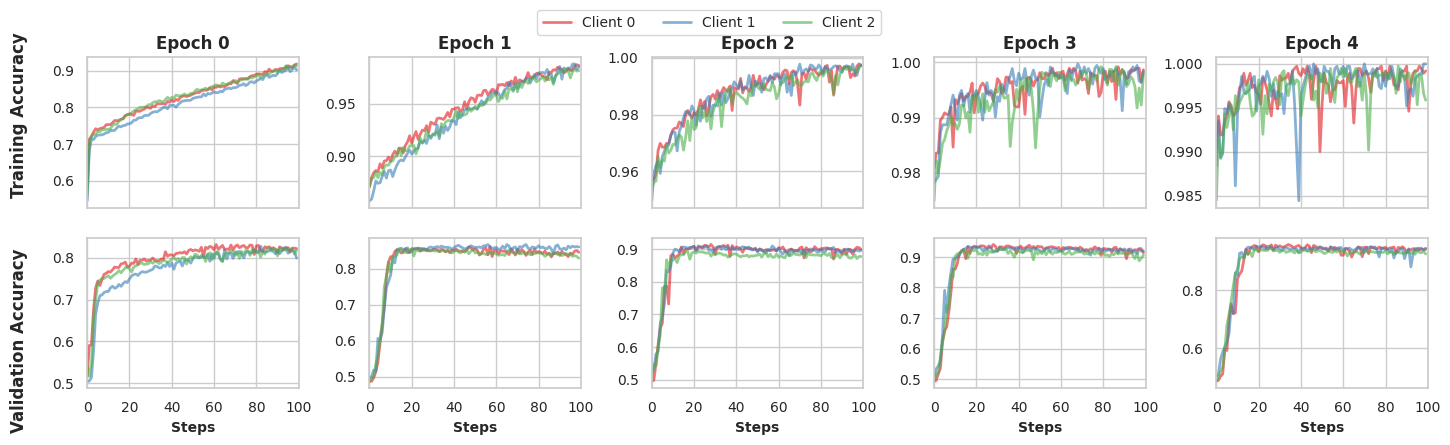

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy
def plot_accuracy(all_metrics_df, unique_epochs, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create subplots for each epoch
    fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Iterate through each epoch and plot the training and validation accuracy
    for i, epoch in enumerate(unique_epochs):
        epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
        for j, client in enumerate(epoch_df['client_number'].unique()):
            client_df = epoch_df[epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
            if not client_df.empty:
                line, = axes[0, i].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
                axes[1, i].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

                if i == 0:
                    lines.append(line)
                    labels.append(f'Client {client}')

        axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
        axes[0, i].grid(True)
        axes[1, i].grid(True)
        axes[0, i].tick_params(axis='both', which='major', labelsize=10)
        axes[1, i].tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

    # Add row labels
    fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Get unique epochs from the dataframe
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Plot the accuracy
plot_accuracy(all_metrics_df, unique_epochs, output_dir)


Final Epoch: 4
Average Training Accuracy: 0.9972
Average Validation Accuracy: 0.9058


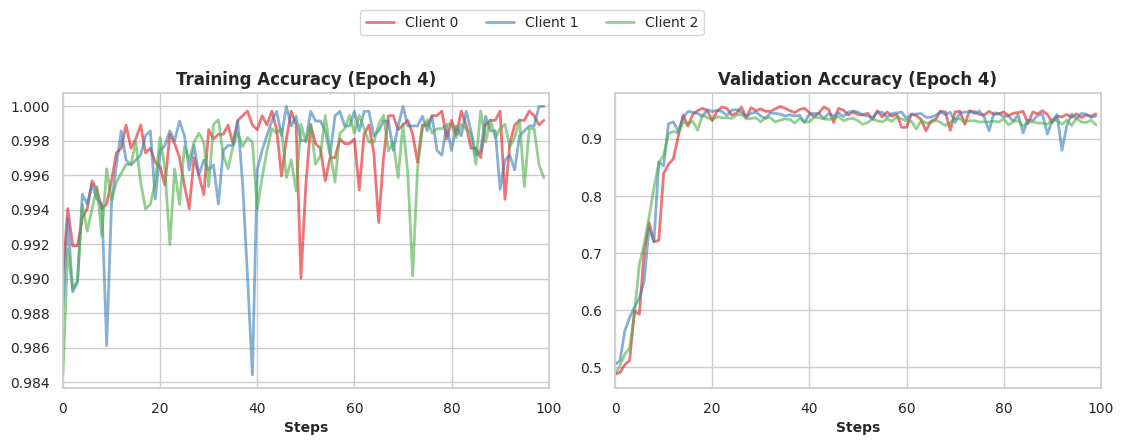

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy for the final epoch
def plot_final_epoch_accuracy(all_metrics_df, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Get the final epoch number
    final_epoch = all_metrics_df['epoch_number'].max()

    # Filter the data for the final epoch
    final_epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == final_epoch]

    # Calculate the average training and validation accuracy for the final epoch
    avg_train_accuracy = final_epoch_df['accuracy'].mean()
    avg_val_accuracy = final_epoch_df['val_accuracy'].mean()

    print(f"Final Epoch: {final_epoch}")
    print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

    # Create subplots for the final epoch
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=final_epoch_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Plot the training and validation accuracy for the final epoch
    for client in final_epoch_df['client_number'].unique():
        client_df = final_epoch_df[final_epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
        if not client_df.empty:
            line, = axes[0].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)
            axes[1].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)

            if len(lines) < final_epoch_df['client_number'].nunique():
                lines.append(line)
                labels.append(f'Client {client}')

    axes[0].set_title(f'Training Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps

    axes[1].set_title(f'Validation Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')


    for ax in axes:
        ax.set_xlabel('Steps', fontsize=10, fontweight='bold')
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=10, frameon=True)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.85)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Plot the accuracy for the final epoch
plot_final_epoch_accuracy(all_metrics_df, output_dir)


# CNN

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/CNN/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/CNN/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 16ms/step - loss: 1.6939 - accuracy: 0.7128 - val_loss: 1.7536 - val_accuracy: 0.7478
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 1.6361 - accuracy: 0.7379 - val_loss: 1.7387 - val_accuracy: 0.7597
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 1.5866 - accuracy: 0.7481 - val_loss: 1.7225 - val_accuracy: 0.7597
Epoch 5/100
29/29 [==============================] - 0s 9ms/step - loss: 1.5585 - accuracy: 0.7487 - val_loss: 1.7063 - val_accuracy: 0.7597
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 1.5402 - accuracy: 0.7516 - val_loss: 1.6915 - val_accuracy: 0.7662
Epoch 7/100
29/29 [==============================] - 0s 16ms/step - loss: 1.5250 - accuracy: 0.7575 - val_loss: 1.6772 - val_accuracy: 0.7694
Epoch 8/100
29/29 [==============================] - 0s 10ms/step - loss: 1.5114 - accuracy: 0.7597 - val_loss: 1.6625 - val_accuracy: 0.7694
Epoch 9/100
29/29 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 74ms/step - loss: 1.7557 - accuracy: 0.5806 - val_loss: 1.7668 - val_accuracy: 0.6414
Epoch 2/100
28/28 [==============================] - 1s 25ms/step - loss: 1.7077 - accuracy: 0.6876 - val_loss: 1.7555 - val_accuracy: 0.7081
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 1.6562 - accuracy: 0.7159 - val_loss: 1.7424 - val_accuracy: 0.6980
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 1.6126 - accuracy: 0.7244 - val_loss: 1.7285 - val_accuracy: 0.7070
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 1.5862 - accuracy: 0.7298 - val_loss: 1.7141 - val_accuracy: 0.7104
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 1.5669 - accuracy: 0.7332 - val_loss: 1.7008 - val_accuracy: 0.7183
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 1.5530 - accuracy: 0.7368 - val_loss: 1.6877 - val_accuracy: 0.7240
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 19ms/step - loss: 1.6914 - accuracy: 0.7070 - val_loss: 1.7521 - val_accuracy: 0.7314
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 1.6345 - accuracy: 0.7253 - val_loss: 1.7372 - val_accuracy: 0.7397
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 1.5923 - accuracy: 0.7372 - val_loss: 1.7205 - val_accuracy: 0.7521
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 1.5666 - accuracy: 0.7364 - val_loss: 1.7048 - val_accuracy: 0.7376
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 1.5485 - accuracy: 0.7421 - val_loss: 1.6899 - val_accuracy: 0.7438
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 1.5300 - accuracy: 0.7460 - val_loss: 1.6752 - val_accuracy: 0.7541
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 1.5140 - accuracy: 0.7501 - val_loss: 1.6597 - val_accuracy: 0.7583
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 15ms/step - loss: 0.7595 - accuracy: 0.9305 - val_loss: 1.2314 - val_accuracy: 0.4914
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7476 - accuracy: 0.9340 - val_loss: 1.2168 - val_accuracy: 0.5065
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7382 - accuracy: 0.9351 - val_loss: 1.2103 - val_accuracy: 0.5032
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 0.7266 - accuracy: 0.9461 - val_loss: 1.1955 - val_accuracy: 0.5216
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7172 - accuracy: 0.9464 - val_loss: 1.1694 - val_accuracy: 0.5700
Epoch 7/100
29/29 [==============================] - 1s 19ms/step - loss: 0.7096 - accuracy: 0.9480 - val_loss: 1.1427 - val_accuracy: 0.6595
Epoch 8/100
29/29 [==============================] - 1s 18ms/step - loss: 0.7057 - accuracy: 0.9485 - val_loss: 1.1193 - val_accuracy: 0.7144
Epoch 9/100
29/29 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 17ms/step - loss: 0.7790 - accuracy: 0.9162 - val_loss: 1.2266 - val_accuracy: 0.5034
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.7680 - accuracy: 0.9196 - val_loss: 1.2180 - val_accuracy: 0.5079
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7575 - accuracy: 0.9267 - val_loss: 1.1997 - val_accuracy: 0.5385
Epoch 5/100
28/28 [==============================] - 0s 12ms/step - loss: 0.7459 - accuracy: 0.9363 - val_loss: 1.1954 - val_accuracy: 0.5283
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.7393 - accuracy: 0.9366 - val_loss: 1.1702 - val_accuracy: 0.6041
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.7284 - accuracy: 0.9394 - val_loss: 1.1527 - val_accuracy: 0.6391
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 0.7216 - accuracy: 0.9434 - val_loss: 1.1317 - val_accuracy: 0.6821
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 16ms/step - loss: 0.7703 - accuracy: 0.9199 - val_loss: 1.2356 - val_accuracy: 0.4876
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.7662 - accuracy: 0.9204 - val_loss: 1.2183 - val_accuracy: 0.5041
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7534 - accuracy: 0.9243 - val_loss: 1.2015 - val_accuracy: 0.5165
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.7424 - accuracy: 0.9300 - val_loss: 1.1935 - val_accuracy: 0.5196
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7333 - accuracy: 0.9323 - val_loss: 1.1602 - val_accuracy: 0.6209
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7302 - accuracy: 0.9328 - val_loss: 1.1373 - val_accuracy: 0.6798
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 0.7226 - accuracy: 0.9331 - val_loss: 1.1331 - val_accuracy: 0.6384
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 15ms/step - loss: 0.4150 - accuracy: 0.9890 - val_loss: 1.0754 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.4072 - accuracy: 0.9941 - val_loss: 1.0712 - val_accuracy: 0.4903
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.4072 - accuracy: 0.9935 - val_loss: 1.0485 - val_accuracy: 0.4957
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 0.3991 - accuracy: 0.9960 - val_loss: 1.0211 - val_accuracy: 0.5216
Epoch 6/100
29/29 [==============================] - 1s 35ms/step - loss: 0.4006 - accuracy: 0.9943 - val_loss: 0.9985 - val_accuracy: 0.5463
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3943 - accuracy: 0.9973 - val_loss: 0.9806 - val_accuracy: 0.5733
Epoch 8/100
29/29 [==============================] - 1s 20ms/step - loss: 0.3911 - accuracy: 0.9968 - val_loss: 0.9161 - val_accuracy: 0.6552
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 18ms/step - loss: 0.4268 - accuracy: 0.9861 - val_loss: 1.0712 - val_accuracy: 0.4989
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.4237 - accuracy: 0.9859 - val_loss: 1.0485 - val_accuracy: 0.5057
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 0.4219 - accuracy: 0.9847 - val_loss: 1.0401 - val_accuracy: 0.5147
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.4088 - accuracy: 0.9918 - val_loss: 1.0189 - val_accuracy: 0.5317
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.4067 - accuracy: 0.9926 - val_loss: 0.9945 - val_accuracy: 0.5645
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 0.4023 - accuracy: 0.9935 - val_loss: 0.9825 - val_accuracy: 0.5758
Epoch 8/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3987 - accuracy: 0.9946 - val_loss: 0.9235 - val_accuracy: 0.6391
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 13ms/step - loss: 0.4355 - accuracy: 0.9806 - val_loss: 1.0836 - val_accuracy: 0.4866
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4371 - accuracy: 0.9809 - val_loss: 1.0591 - val_accuracy: 0.4969
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.4211 - accuracy: 0.9871 - val_loss: 1.0656 - val_accuracy: 0.4959
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.4174 - accuracy: 0.9868 - val_loss: 1.0226 - val_accuracy: 0.5196
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4109 - accuracy: 0.9907 - val_loss: 1.0033 - val_accuracy: 0.5362
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 0.4065 - accuracy: 0.9902 - val_loss: 0.9513 - val_accuracy: 0.6085
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4053 - accuracy: 0.9907 - val_loss: 0.9363 - val_accuracy: 0.6271
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 17ms/step - loss: 0.2930 - accuracy: 0.9949 - val_loss: 1.0059 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.2856 - accuracy: 0.9970 - val_loss: 0.9988 - val_accuracy: 0.4892
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 0.2838 - accuracy: 0.9989 - val_loss: 0.9826 - val_accuracy: 0.4957
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.2811 - accuracy: 0.9995 - val_loss: 0.9683 - val_accuracy: 0.5011
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.2819 - accuracy: 0.9992 - val_loss: 0.9508 - val_accuracy: 0.5129
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.2796 - accuracy: 0.9995 - val_loss: 0.8967 - val_accuracy: 0.5700
Epoch 8/100
29/29 [==============================] - 0s 16ms/step - loss: 0.2781 - accuracy: 0.9995 - val_loss: 0.8678 - val_accuracy: 0.6013
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 38ms/step - loss: 0.3058 - accuracy: 0.9904 - val_loss: 0.9936 - val_accuracy: 0.4977
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.2931 - accuracy: 0.9958 - val_loss: 0.9926 - val_accuracy: 0.4977
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.2879 - accuracy: 0.9975 - val_loss: 0.9883 - val_accuracy: 0.4989
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.2840 - accuracy: 0.9992 - val_loss: 0.9730 - val_accuracy: 0.5045
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.2827 - accuracy: 0.9989 - val_loss: 0.9494 - val_accuracy: 0.5158
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.2816 - accuracy: 0.9989 - val_loss: 0.9314 - val_accuracy: 0.5294
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.2795 - accuracy: 0.9997 - val_loss: 0.8905 - val_accuracy: 0.5724
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 11ms/step - loss: 0.2977 - accuracy: 0.9925 - val_loss: 1.0139 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2916 - accuracy: 0.9972 - val_loss: 1.0092 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.2867 - accuracy: 0.9977 - val_loss: 0.9929 - val_accuracy: 0.4948
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.2855 - accuracy: 0.9979 - val_loss: 0.9943 - val_accuracy: 0.4969
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 0.2853 - accuracy: 0.9984 - val_loss: 0.9479 - val_accuracy: 0.5186
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.2816 - accuracy: 0.9990 - val_loss: 0.9164 - val_accuracy: 0.5444
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 0.2809 - accuracy: 1.0000 - val_loss: 0.8584 - val_accuracy: 0.5992
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 22ms/step - loss: 0.2041 - accuracy: 0.9981 - val_loss: 0.9378 - val_accuracy: 0.4871
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.2021 - accuracy: 0.9989 - val_loss: 0.9308 - val_accuracy: 0.4892
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.2027 - accuracy: 0.9992 - val_loss: 0.9155 - val_accuracy: 0.4935
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 0.2005 - accuracy: 0.9995 - val_loss: 0.8928 - val_accuracy: 0.5032
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.1997 - accuracy: 0.9997 - val_loss: 0.8647 - val_accuracy: 0.5226
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.1989 - accuracy: 0.9995 - val_loss: 0.8458 - val_accuracy: 0.5463
Epoch 8/100
29/29 [==============================] - 0s 16ms/step - loss: 0.1987 - accuracy: 0.9995 - val_loss: 0.7878 - val_accuracy: 0.5981
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 16ms/step - loss: 0.2054 - accuracy: 0.9980 - val_loss: 0.9306 - val_accuracy: 0.4977
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 0.9994 - val_loss: 0.9268 - val_accuracy: 0.4989
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.2012 - accuracy: 0.9997 - val_loss: 0.9117 - val_accuracy: 0.5034
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.2003 - accuracy: 0.9997 - val_loss: 0.8760 - val_accuracy: 0.5158
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.1999 - accuracy: 0.9997 - val_loss: 0.8610 - val_accuracy: 0.5362
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.1989 - accuracy: 1.0000 - val_loss: 0.8254 - val_accuracy: 0.5611
Epoch 8/100
28/28 [==============================] - 1s 19ms/step - loss: 0.1983 - accuracy: 1.0000 - val_loss: 0.7810 - val_accuracy: 0.6018
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 13ms/step - loss: 0.2074 - accuracy: 0.9982 - val_loss: 0.9517 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.2039 - accuracy: 0.9995 - val_loss: 0.9416 - val_accuracy: 0.4886
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.2027 - accuracy: 0.9995 - val_loss: 0.9337 - val_accuracy: 0.4928
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.2015 - accuracy: 0.9997 - val_loss: 0.9259 - val_accuracy: 0.4979
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 0.8947 - val_accuracy: 0.5103
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 0.8444 - val_accuracy: 0.5444
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 0.7814 - val_accuracy: 0.5961
Epoch 9/100
31/31 

In [ ]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.747,0.747,0.747,0.747,0.747,0.747,0.494
1,1,0.792,0.805,0.771,0.788,0.771,0.814,0.585
2,2,0.736,0.709,0.799,0.752,0.799,0.673,0.472
3,0,0.798,0.791,0.811,0.801,0.811,0.786,0.596
4,1,0.849,0.853,0.843,0.848,0.843,0.855,0.698
5,2,0.806,0.806,0.807,0.806,0.807,0.805,0.612
6,0,0.838,0.817,0.869,0.843,0.869,0.806,0.675
7,1,0.886,0.859,0.922,0.890,0.922,0.849,0.771
8,2,0.863,0.824,0.924,0.871,0.924,0.803,0.727
9,0,0.874,0.854,0.901,0.877,0.901,0.846,0.747


In [ ]:
metrics_df_CNN.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/CNN/frequency_CNN.csv', index = False)

# GRU

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model_gru(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning_gru(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model_gru(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model_gru(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/CNN_GRU/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Total/CNN_GRU/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model_gru, metrics_df_gru = federated_learning_gru(Theta_data)

Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 53ms/step - loss: 1.4305 - accuracy: 0.5625 - val_loss: 1.4295 - val_accuracy: 0.5776
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 1.4191 - accuracy: 0.6342 - val_loss: 1.4232 - val_accuracy: 0.7241
Epoch 3/100
29/29 [==============================] - 1s 25ms/step - loss: 1.4030 - accuracy: 0.6794 - val_loss: 1.4165 - val_accuracy: 0.7371
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 1.3776 - accuracy: 0.7031 - val_loss: 1.4085 - val_accuracy: 0.7511
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 1.3401 - accuracy: 0.7223 - val_loss: 1.3976 - val_accuracy: 0.7489
Epoch 6/100
29/29 [==============================] - 1s 22ms/step - loss: 1.2963 - accuracy: 0.7373 - val_loss: 1.3835 - val_accuracy: 0.7554
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 1.2558 - accuracy: 0.7395 - val_loss: 1.3661 - val_accuracy: 0.7478
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 1.4218 - accuracy: 0.6024 - val_loss: 1.4238 - val_accuracy: 0.6991
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 1.4085 - accuracy: 0.6579 - val_loss: 1.4177 - val_accuracy: 0.6934
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 1.3893 - accuracy: 0.6839 - val_loss: 1.4107 - val_accuracy: 0.6934
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 1.3595 - accuracy: 0.7046 - val_loss: 1.4022 - val_accuracy: 0.7036
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 1.3228 - accuracy: 0.7131 - val_loss: 1.3918 - val_accuracy: 0.7104
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 1.2873 - accuracy: 0.7221 - val_loss: 1.3777 - val_accuracy: 0.7036
Epoch 8/100
28/28 [==============================] - 1s 20ms/step - loss: 1.2590 - accuracy: 0.7298 - val_loss: 1.3635 - val_accuracy: 0.7149
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 1.4189 - accuracy: 0.6124 - val_loss: 1.4226 - val_accuracy: 0.6890
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 1.4022 - accuracy: 0.6535 - val_loss: 1.4155 - val_accuracy: 0.7231
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 1.3753 - accuracy: 0.7000 - val_loss: 1.4069 - val_accuracy: 0.7428
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 1.3384 - accuracy: 0.7140 - val_loss: 1.3957 - val_accuracy: 0.7438
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 1.2934 - accuracy: 0.7276 - val_loss: 1.3815 - val_accuracy: 0.7376
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 1.2588 - accuracy: 0.7370 - val_loss: 1.3642 - val_accuracy: 0.7490
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 1.2369 - accuracy: 0.7362 - val_loss: 1.3481 - val_accuracy: 0.7490
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 47ms/step - loss: 0.7094 - accuracy: 0.8839 - val_loss: 1.1219 - val_accuracy: 0.4860
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.6870 - accuracy: 0.8930 - val_loss: 1.1197 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6850 - accuracy: 0.8960 - val_loss: 1.1111 - val_accuracy: 0.4871
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 0.6691 - accuracy: 0.9030 - val_loss: 1.1059 - val_accuracy: 0.4871
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6687 - accuracy: 0.9025 - val_loss: 1.0934 - val_accuracy: 0.4892
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.6574 - accuracy: 0.9065 - val_loss: 1.0745 - val_accuracy: 0.5022
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.6538 - accuracy: 0.9049 - val_loss: 1.0651 - val_accuracy: 0.5097
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 72ms/step - loss: 0.7189 - accuracy: 0.8752 - val_loss: 1.1226 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.6969 - accuracy: 0.8871 - val_loss: 1.1166 - val_accuracy: 0.4966
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.6928 - accuracy: 0.8899 - val_loss: 1.1035 - val_accuracy: 0.4977
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6915 - accuracy: 0.8879 - val_loss: 1.0973 - val_accuracy: 0.4977
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.6792 - accuracy: 0.8933 - val_loss: 1.0876 - val_accuracy: 0.5011
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 0.6703 - accuracy: 0.8964 - val_loss: 1.0767 - val_accuracy: 0.5079
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 0.6657 - accuracy: 0.9007 - val_loss: 1.0603 - val_accuracy: 0.5283
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.8935 - val_loss: 1.1181 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 0.6807 - accuracy: 0.8972 - val_loss: 1.1070 - val_accuracy: 0.4876
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 0.6761 - accuracy: 0.8987 - val_loss: 1.0960 - val_accuracy: 0.4907
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 0.6624 - accuracy: 0.9080 - val_loss: 1.0875 - val_accuracy: 0.4938
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 0.6584 - accuracy: 0.9052 - val_loss: 1.0721 - val_accuracy: 0.5062
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6568 - accuracy: 0.9010 - val_loss: 1.0623 - val_accuracy: 0.5103
Epoch 8/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6495 - accuracy: 0.9072 - val_loss: 1.0444 - val_accuracy: 0.5475
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 48ms/step - loss: 0.3880 - accuracy: 0.9631 - val_loss: 0.9925 - val_accuracy: 0.4860
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.3734 - accuracy: 0.9690 - val_loss: 0.9880 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 0s 11ms/step - loss: 0.3557 - accuracy: 0.9752 - val_loss: 0.9848 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.3503 - accuracy: 0.9768 - val_loss: 0.9777 - val_accuracy: 0.4871
Epoch 5/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3460 - accuracy: 0.9766 - val_loss: 0.9628 - val_accuracy: 0.4978
Epoch 6/100
29/29 [==============================] - 1s 22ms/step - loss: 0.3476 - accuracy: 0.9766 - val_loss: 0.9455 - val_accuracy: 0.5032
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3490 - accuracy: 0.9736 - val_loss: 0.9421 - val_accuracy: 0.5097
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 51ms/step - loss: 0.3930 - accuracy: 0.9587 - val_loss: 0.9907 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 0.3699 - accuracy: 0.9689 - val_loss: 0.9857 - val_accuracy: 0.4966
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 0.3599 - accuracy: 0.9731 - val_loss: 0.9792 - val_accuracy: 0.4989
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 0.3538 - accuracy: 0.9745 - val_loss: 0.9725 - val_accuracy: 0.5023
Epoch 5/100
28/28 [==============================] - 0s 14ms/step - loss: 0.3575 - accuracy: 0.9720 - val_loss: 0.9597 - val_accuracy: 0.5023
Epoch 6/100
28/28 [==============================] - 1s 20ms/step - loss: 0.3527 - accuracy: 0.9731 - val_loss: 0.9564 - val_accuracy: 0.5079
Epoch 7/100
28/28 [==============================] - 1s 23ms/step - loss: 0.3444 - accuracy: 0.9771 - val_loss: 0.9323 - val_accuracy: 0.5271
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 11s 151ms/step - loss: 0.3911 - accuracy: 0.9612 - val_loss: 0.9924 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 0.3804 - accuracy: 0.9615 - val_loss: 0.9902 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 33ms/step - loss: 0.3595 - accuracy: 0.9713 - val_loss: 0.9856 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 0.3544 - accuracy: 0.9742 - val_loss: 0.9774 - val_accuracy: 0.4897
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 0.3529 - accuracy: 0.9726 - val_loss: 0.9731 - val_accuracy: 0.4959
Epoch 6/100
31/31 [==============================] - 1s 39ms/step - loss: 0.3543 - accuracy: 0.9721 - val_loss: 0.9350 - val_accuracy: 0.5186
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.3455 - accuracy: 0.9762 - val_loss: 0.9344 - val_accuracy: 0.5196
Epoch 8/100
31/3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 55ms/step - loss: 0.2477 - accuracy: 0.9844 - val_loss: 0.9320 - val_accuracy: 0.4860
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 0.2424 - accuracy: 0.9863 - val_loss: 0.9282 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 0.2443 - accuracy: 0.9849 - val_loss: 0.9217 - val_accuracy: 0.4881
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2247 - accuracy: 0.9919 - val_loss: 0.9167 - val_accuracy: 0.4903
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.2247 - accuracy: 0.9930 - val_loss: 0.9135 - val_accuracy: 0.4957
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2217 - accuracy: 0.9943 - val_loss: 0.8766 - val_accuracy: 0.5075
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.2213 - accuracy: 0.9930 - val_loss: 0.8573 - val_accuracy: 0.5291
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 10s 51ms/step - loss: 0.2622 - accuracy: 0.9791 - val_loss: 0.9242 - val_accuracy: 0.4966
Epoch 2/100
28/28 [==============================] - 1s 21ms/step - loss: 0.2403 - accuracy: 0.9875 - val_loss: 0.9228 - val_accuracy: 0.4989
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2288 - accuracy: 0.9921 - val_loss: 0.9190 - val_accuracy: 0.4989
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 0.2359 - accuracy: 0.9884 - val_loss: 0.9089 - val_accuracy: 0.5011
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.2307 - accuracy: 0.9918 - val_loss: 0.8915 - val_accuracy: 0.5079
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 0.2278 - accuracy: 0.9924 - val_loss: 0.8732 - val_accuracy: 0.5226
Epoch 7/100
28/28 [==============================] - 1s 23ms/step - loss: 0.2228 - accuracy: 0.9938 - val_loss: 0.8744 - val_accuracy: 0.5249
Epoch 8/100
28/28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.2475 - accuracy: 0.9822 - val_loss: 0.9333 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.2371 - accuracy: 0.9876 - val_loss: 0.9235 - val_accuracy: 0.4886
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 0.2289 - accuracy: 0.9897 - val_loss: 0.9230 - val_accuracy: 0.4907
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 0.2319 - accuracy: 0.9881 - val_loss: 0.9103 - val_accuracy: 0.4990
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 0.2236 - accuracy: 0.9930 - val_loss: 0.8896 - val_accuracy: 0.5103
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 0.2230 - accuracy: 0.9935 - val_loss: 0.8764 - val_accuracy: 0.5207
Epoch 8/100
31/31 [==============================] - 1s 29ms/step - loss: 0.2257 - accuracy: 0.9891 - val_loss: 0.8146 - val_accuracy: 0.5795
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 49ms/step - loss: 0.1827 - accuracy: 0.9914 - val_loss: 0.8998 - val_accuracy: 0.4860
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.1732 - accuracy: 0.9922 - val_loss: 0.8925 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.1658 - accuracy: 0.9965 - val_loss: 0.8919 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.1625 - accuracy: 0.9978 - val_loss: 0.8872 - val_accuracy: 0.4914
Epoch 5/100
29/29 [==============================] - 1s 21ms/step - loss: 0.1625 - accuracy: 0.9981 - val_loss: 0.8771 - val_accuracy: 0.4989
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.1642 - accuracy: 0.9946 - val_loss: 0.8592 - val_accuracy: 0.5011
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 0.1616 - accuracy: 0.9968 - val_loss: 0.8201 - val_accuracy: 0.5205
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 74ms/step - loss: 0.1920 - accuracy: 0.9875 - val_loss: 0.8937 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 32ms/step - loss: 0.1791 - accuracy: 0.9912 - val_loss: 0.8836 - val_accuracy: 0.4977
Epoch 3/100
28/28 [==============================] - 1s 31ms/step - loss: 0.1715 - accuracy: 0.9958 - val_loss: 0.8809 - val_accuracy: 0.4989
Epoch 4/100
28/28 [==============================] - 1s 41ms/step - loss: 0.1666 - accuracy: 0.9963 - val_loss: 0.8714 - val_accuracy: 0.5023
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.1656 - accuracy: 0.9969 - val_loss: 0.8569 - val_accuracy: 0.5090
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 0.1627 - accuracy: 0.9975 - val_loss: 0.8300 - val_accuracy: 0.5215
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 0.1629 - accuracy: 0.9977 - val_loss: 0.8121 - val_accuracy: 0.5407
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1704 - accuracy: 0.9951 - val_loss: 0.8964 - val_accuracy: 0.4876
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.1713 - accuracy: 0.9938 - val_loss: 0.8982 - val_accuracy: 0.4886
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.1777 - accuracy: 0.9897 - val_loss: 0.8699 - val_accuracy: 0.4959
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1762 - accuracy: 0.9925 - val_loss: 0.8881 - val_accuracy: 0.4959
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1664 - accuracy: 0.9956 - val_loss: 0.8458 - val_accuracy: 0.5145
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1641 - accuracy: 0.9974 - val_loss: 0.8006 - val_accuracy: 0.5393
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1653 - accuracy: 0.9961 - val_loss: 0.8098 - val_accuracy: 0.5424
Epoch 

In [ ]:
metrics_df_gru

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.764657,0.759868,0.773869,0.766805,0.773869,0.755444,0.529313
1,1,0.805085,0.793478,0.824859,0.808864,0.824859,0.785311,0.610169
2,2,0.736948,0.733202,0.744980,0.739044,0.744980,0.728916,0.473896
3,0,0.813233,0.773392,0.886097,0.825917,0.886097,0.740369,0.626466
4,1,0.831215,0.798726,0.885593,0.839920,0.885593,0.776836,0.662429
5,2,0.816265,0.798861,0.845382,0.821463,0.845382,0.787149,0.632530
6,0,0.866834,0.852090,0.887772,0.869565,0.887772,0.845896,0.733668
7,1,0.888418,0.900875,0.872881,0.886657,0.872881,0.903955,0.776836
8,2,0.869478,0.845865,0.903614,0.873786,0.903614,0.835341,0.738956
9,0,0.892797,0.866980,0.927973,0.896440,0.927973,0.857621,0.785595


In [ ]:
metrics_df_gru.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/GRU/frequency_gru.csv', index = False)